In [1]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from pathlib import Path
import nibabel as nib
import re
from skimage import measure
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [2]:
images_path = "/Users/ciro/Documents/dataset"


## Load and Preprocess Data

This section sets up the data loading process. It defines a limit of 300 images to process, which helps manage computational resources. The load_nii function uses the nibabel library to load NIfTI format neuroimaging files. The get_images_and_masks function is crucial - it navigates through the directory structure, randomly samples image files (up to the limit), and loads different MRI modalities (FLAIR, T1, T1ce, T2) along with their corresponding segmentation masks. This function is called for both high-grade (HGG) and low-grade (LGG) gliomas.



In [3]:

 
import random

limit = 300
images = []
masks = []

def load_nii(file_path):
    """Load a NIfTI file."""
    return nib.load(file_path).get_fdata()

def get_images_and_masks(grade):
    grade_dir = os.path.join(images_path, grade)
    all_files = [imgname for imgname in os.listdir(grade_dir) if imgname != ".DS_Store"]
    sampled_files = random.sample(all_files, min(limit, len(all_files)))

    for imgname in sampled_files:
        modalities = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        image_paths = [os.path.join(grade_dir, imgname, f"{imgname}{modality}") for modality in modalities]
        mask_path = os.path.join(grade_dir, imgname, f"{imgname}_seg.nii")
        images.append(image_paths)
        masks.append(mask_path)

get_images_and_masks('HGG')
get_images_and_masks('LGG')

print("Number of image sets loaded:", len(images))
print("Number of masks loaded:", len(masks))




Number of image sets loaded: 335
Number of masks loaded: 335


## Image Processing:


These functions handle the core image processing tasks. normalize_image performs z-score normalization, which is crucial for ensuring that all images are on a similar scale. binarize_image creates a binary mask based on a threshold, which is useful for segmentation tasks. preprocess_images applies these operations to the different MRI modalities and combines binary versions of FLAIR and T2 images, which are often the most informative for tumor segmentation.

In [4]:
def normalize_image(image):
    return (image - np.mean(image)) / np.std(image)

def binarize_image(image, threshold):
    return (image > threshold).astype(np.uint8)

def preprocess_images(image_paths):
    modalities = ['flair', 't1', 't1ce', 't2']
    images = {modality: normalize_image(load_nii(image_paths[i])) for i, modality in enumerate(modalities)}
    thresholds = {'flair': 0.7, 't2': 0.7, 't1ce': 0.9}
    binary_images = {modality: binarize_image(images[modality], thresholds[modality]) for modality in thresholds}
    combined_binary = np.logical_and(binary_images['flair'], binary_images['t2']).astype(np.uint8)
    return combined_binary

## Select the Best Slice

This function is crucial for working with 3D MRI data. It selects the 2D slice from each 3D volume that contains the most information (i.e., the slice with the largest tumor area). This is a common technique to reduce 3D data to 2D for simplicity, though it does lose some 3D context.

In [5]:
def select_best_slice(binary_image):
    slice_scores = [np.sum(binary_image[:, :, i]) for i in range(binary_image.shape[2])]
    best_slice = np.argmax(slice_scores)
    return best_slice

best_slices = []
for i in range(len(images)):
    image_paths = images[i]
    mask_path = masks[i]

    # Preprocess images to get combined binary image
    binary_image = preprocess_images(image_paths)

    # Load and preprocess mask separately
    mask = load_nii(mask_path)
    binary_mask = binarize_image(mask, 0.5)  # Assuming mask threshold of 0.5 for binarization

    # Select best slice for the mask
    best_slice = select_best_slice(binary_mask)
    best_slices.append(best_slice)


## Data Preparation and Visualization:


This section finalizes the data preparation. It converts the lists of images and masks to numpy arrays, normalizes the image data to the range [0, 1], and ensures the masks are binary. The visualization code that follows is crucial for verifying that the data has been processed correctly.

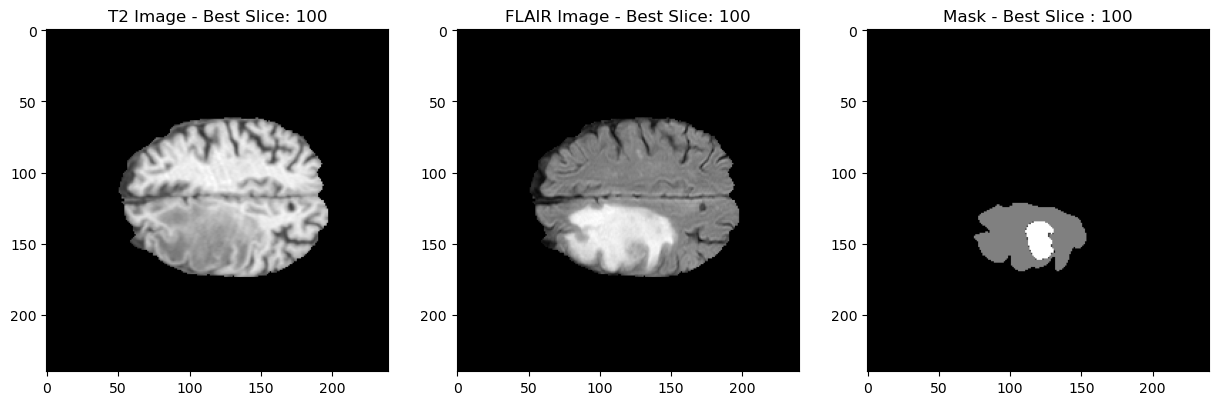

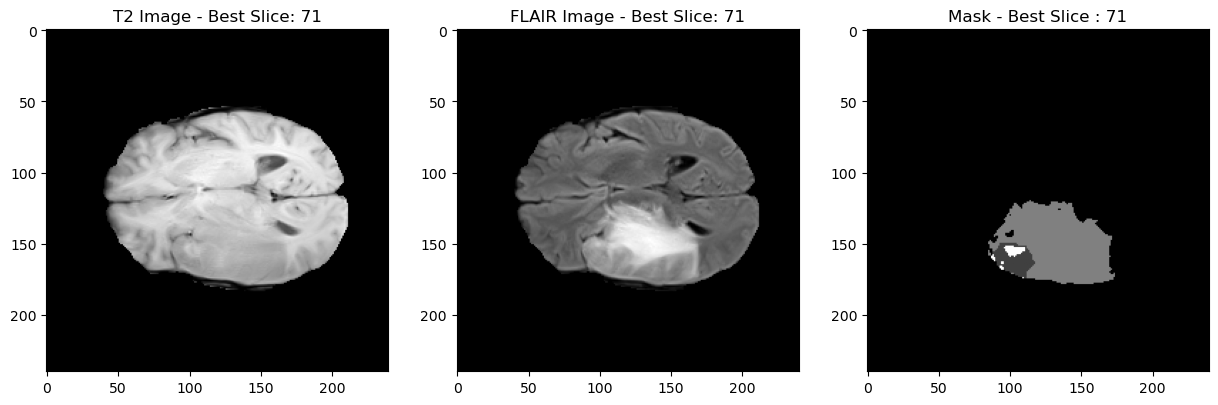

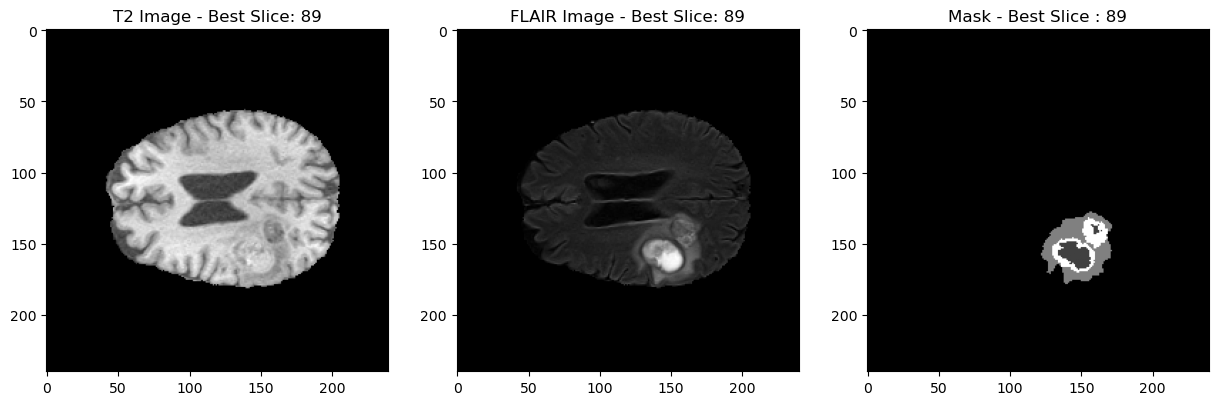

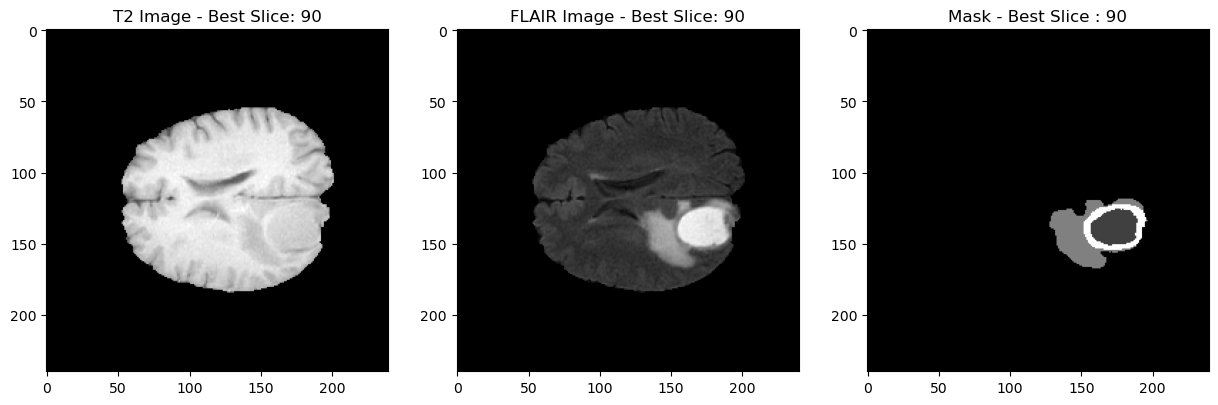

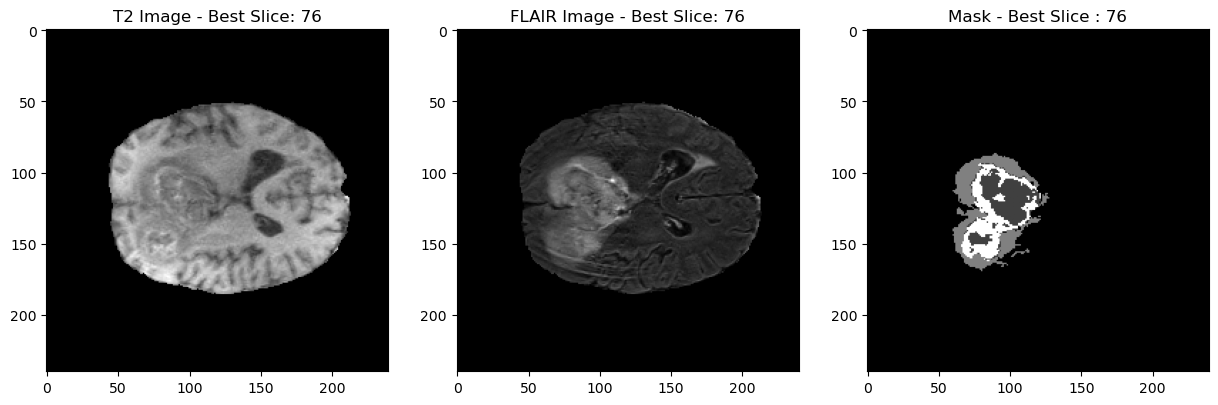

In [6]:

def visualize_slices(images, masks, best_slices, num_to_visualize=5):
    for i in range(min(num_to_visualize, len(images))):
        image_paths = images[i]
        mask_path = masks[i]
        best_slice = best_slices[i]
        
        flair_image = load_nii(image_paths[0])
        t2_image = load_nii(image_paths[1])
        mask = load_nii(mask_path)
        
        plt.figure(figsize=(15, 5))
       
        plt.subplot(1, 3, 1)
        plt.title(f'T2 Image - Best Slice: {best_slice}')
        plt.imshow(t2_image[:, :, best_slice], cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title(f"FLAIR Image - Best Slice: {best_slice}")
        plt.imshow(flair_image[:, :, best_slice], cmap='gray')

         
        

        plt.subplot(1, 3, 3)
        plt.title(f"Mask - Best Slice : {best_slice}")
        plt.imshow(mask[:, :, best_slice], cmap='gray')
        
        plt.show()

visualize_slices(images, masks, best_slices)



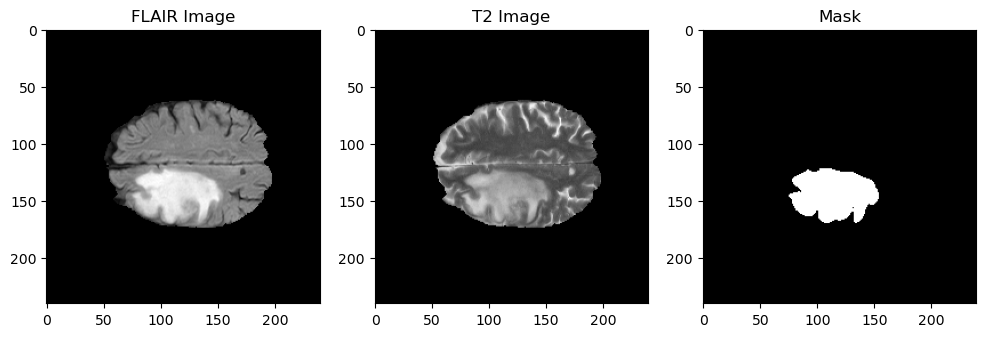

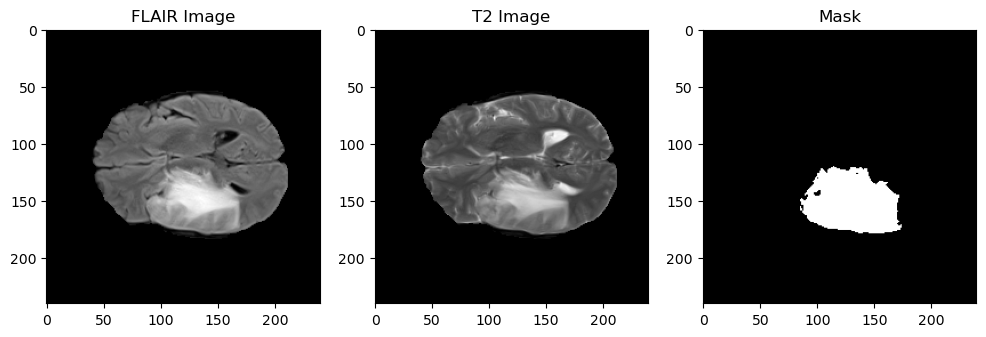

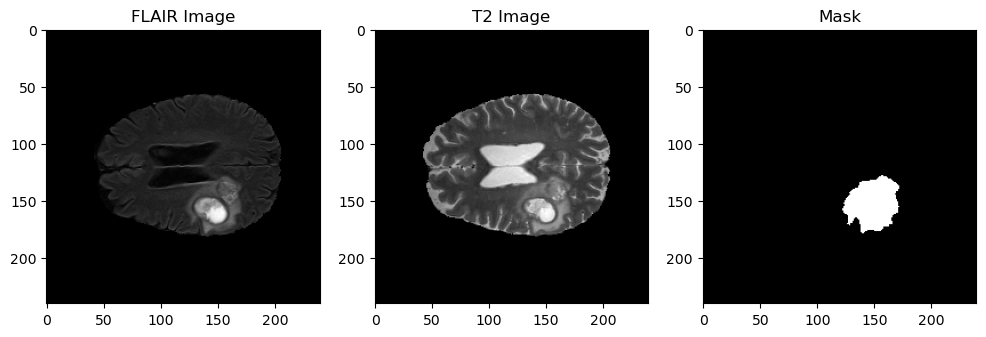

In [31]:
X = []
Y = []

for i in range(len(images)):
    image_paths = images[i]
    mask_path = masks[i]
    best_slice = best_slices[i]

    # Load images and select the best slice
    flair_image = load_nii(image_paths[0])[:, :, best_slice]
    t2_image = load_nii(image_paths[3])[:, :, best_slice]
    
    # Stack the selected modalities
    combined_image = np.stack((flair_image, t2_image), axis=-1)
    X.append(combined_image)
    
    # Load the mask and select the best slice
    mask = load_nii(mask_path)[:, :, best_slice]
    Y.append(mask)

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Normalize images and binarize masks
X = X / np.max(X)
Y = (Y > 0).astype(np.uint8)

# Visualize some examples to ensure data correctness
for i in range(3):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('FLAIR Image')
    plt.imshow(X[i, :, :, 0], cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title('T2 Image')
    plt.imshow(X[i, :, :, 1], cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title('Mask')
    plt.imshow(Y[i], cmap='gray')
    
    plt.show()


## Define the U-Net Model
This function defines the U-Net architecture, a popular choice for medical image segmentation. It consists of an encoder path that downsamples the image, extracting features at multiple scales, and a decoder path that upsamples the features back to the original image size. Skip connections between the encoder and decoder help preserve fine-grained details. The model uses Conv2D layers for feature extraction, MaxPooling2D for downsampling, and UpSampling2D for upsampling. Dropout layers are included for regularization.

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU

def unet(input_size=(256, 256, 2)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs, conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy, metrics=[MeanIoU(num_classes=2)])
    
    return model

model = unet(input_size=(X.shape[1], X.shape[2], X.shape[3]))
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 240, 240,  │      1,216 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 240, 240,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 120, 120,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 120, 120,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 60, 60,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 60,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 30, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 30, 30,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 30,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 15, 15,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 15, 15,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 15, 15,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 15,    │          0 │ conv2d_9[0][0]  

 Total params: 31,032,261 (118.38 MB)

 Trainable params: 31,032,261 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model
This section sets up the training process. It defines callbacks for model checkpointing (saving the best model) and early stopping (to prevent overfitting). The data is split into training and validation sets. The fit method trains the model, using the validation data to monitor performance.

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('unet_brain_tumor_segmentation2.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)



In [85]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=4, callbacks=[checkpoint, early_stopping])


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.5095 - mean_io_u_2: 0.4777
Epoch 1: val_loss improved from inf to 0.13543, saving model to unet_brain_tumor_segmentation2.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - loss: 0.5068 - mean_io_u_2: 0.4777 - val_loss: 0.1354 - val_mean_io_u_2: 0.4792
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1176 - mean_io_u_2: 0.4775
Epoch 2: val_loss improved from 0.13543 to 0.10420, saving model to unet_brain_tumor_segmentation2.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 352s 5s/step - loss: 0.1176 - mean_io_u_2: 0.4775 - val_loss: 0.1042 - val_mean_io_u_2: 0.4792
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1036 - mean_io_u_2: 0.4777
Epoch 3: val_loss improved from 0.10420 to 0.10147, saving model to unet_brain_tumor_segmentation2.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 346s 5s/step - loss: 0.1036 - mean_io_u_2: 0.4777 - val_loss: 0.1015 - val_mean_io_u_2: 0.4792
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - loss: 0.0973 

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


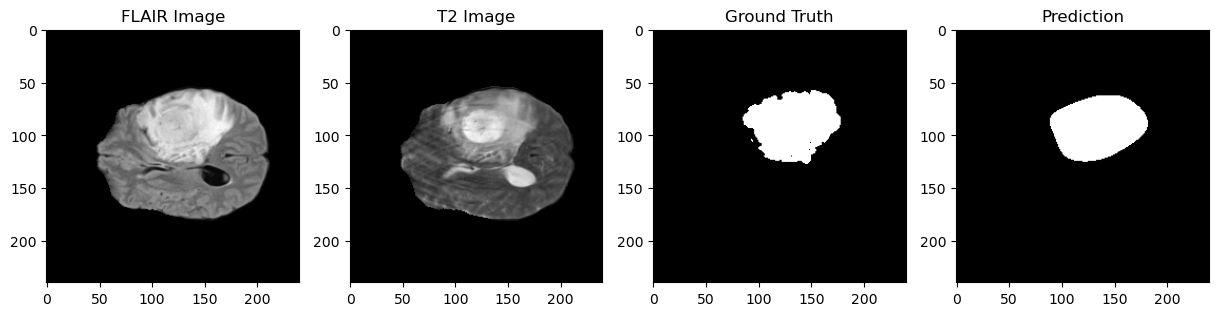

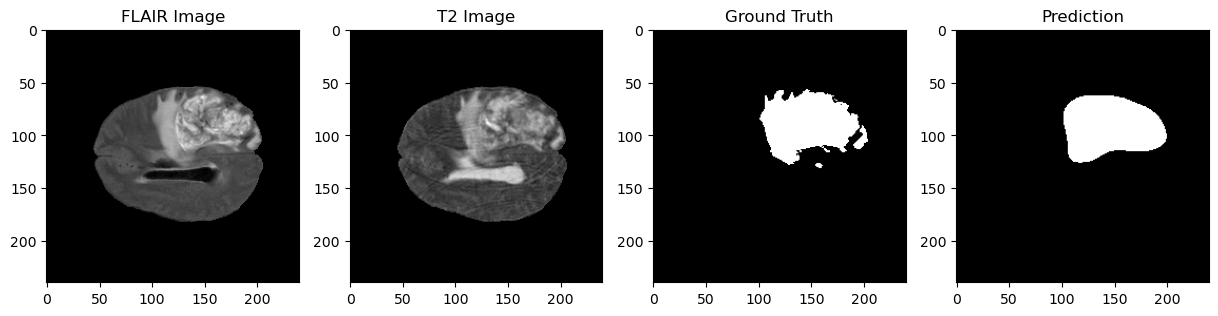

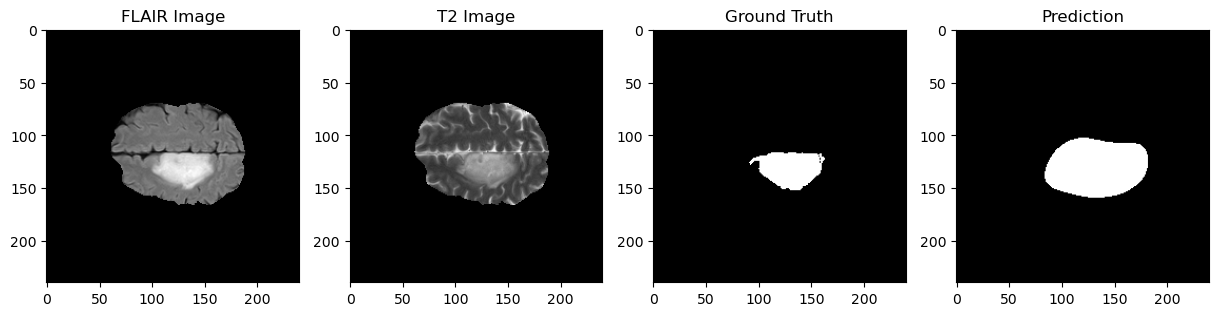

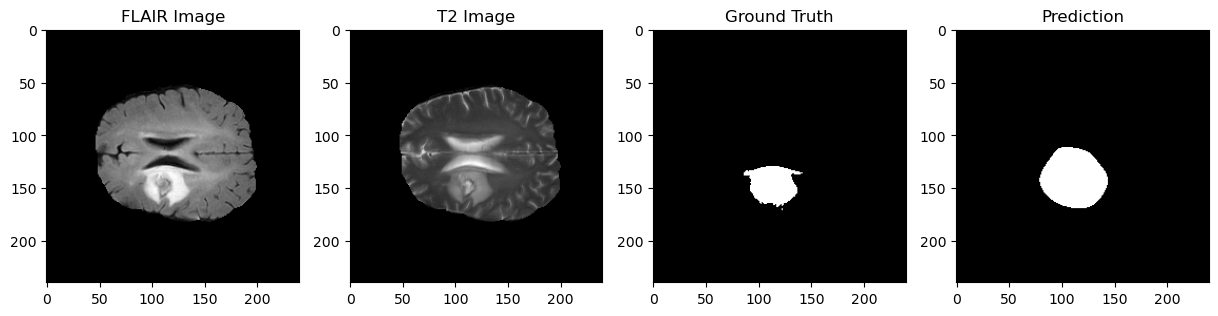

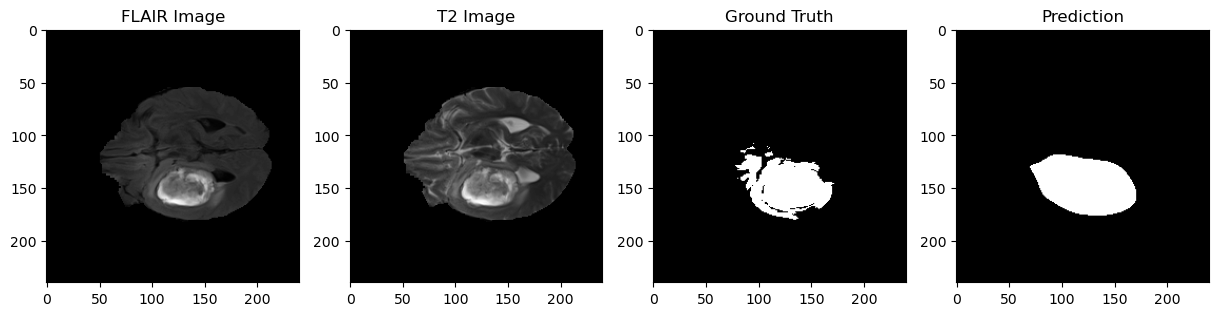

In [87]:
preds = model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)
num_images_to_show = 5
indices = np.random.choice(len(X_val), num_images_to_show, replace=False)

for idx in indices:
    plt.figure(figsize=(15, 5))
    
    # FLAIR image
    plt.subplot(1, 4, 1)
    plt.title('FLAIR Image')
    plt.imshow(X_val[idx, :, :, 0], cmap='gray')
    
    # T2 image
    plt.subplot(1, 4, 2)
    plt.title('T2 Image')
    plt.imshow(X_val[idx, :, :, 1], cmap='gray')
    
    # Ground Truth
    plt.subplot(1, 4, 3)
    plt.title('Ground Truth')
    plt.imshow(Y_val[idx], cmap='gray')
    
    # Prediction
    plt.subplot(1, 4, 4)
    plt.title('Prediction')
    plt.imshow(preds[idx, :, :, 0], cmap='gray')
    
    plt.show()


In [1]:

#model=load_model('unet_brain_tumor_segmentation2.keras')

In [33]:
# Load the best model
model.load_weights('unet_brain_tumor_segmentation2.keras')

# Evaluate the model on the validation set
val_loss, val_miou = model.evaluate(X_val, Y_val)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 0.0536 - mean_io_u: 0.4768


Validation Loss: 0.054264333099126816
Validation Mean IoU: 0.47688665986061096
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step
Dice Score for sample 0: 0.6573638708240006


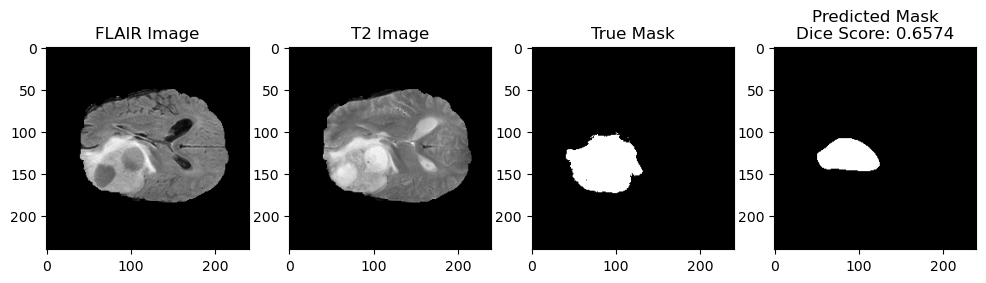

Dice Score for sample 1: 0.876997398782238


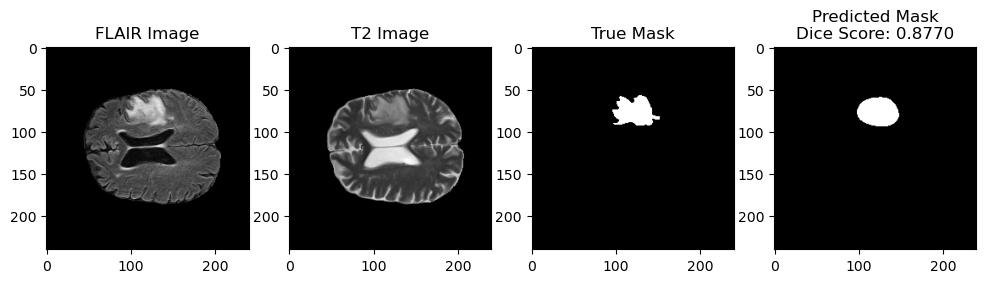

Dice Score for sample 2: 0.8046775078010822


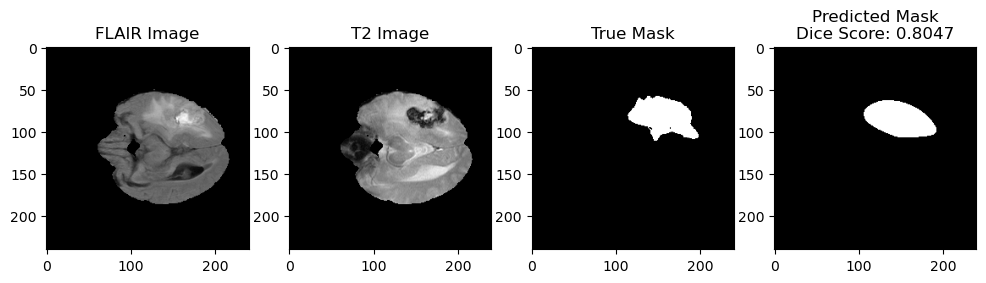

In [11]:

print(f"Validation Loss: {val_loss}")
print(f"Validation Mean IoU: {val_miou}")

# Function to calculate Dice score
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Predict the masks on the validation set
preds = model.predict(X_val)

# Binarize the predictions
preds_bin = (preds > 0.5).astype(np.uint8)

# Visualize predictions and calculate Dice scores
for i in range(3):
    true_mask = Y_val[i]
    predicted_mask = preds_bin[i, :, :, 0]
    
    dice = dice_score(true_mask, predicted_mask)
    print(f"Dice Score for sample {i}: {dice}")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 4, 1)
    plt.title('FLAIR Image')
    plt.imshow(X_val[i, :, :, 0], cmap='gray')
    
    plt.subplot(1, 4, 2)
    plt.title('T2 Image')
    plt.imshow(X_val[i, :, :, 1], cmap='gray')
    
    plt.subplot(1, 4, 3)
    plt.title('True Mask')
    plt.imshow(true_mask, cmap='gray')
    
    plt.subplot(1, 4, 4)
    plt.title(f'Predicted Mask\nDice Score: {dice:.4f}')
    plt.imshow(predicted_mask, cmap='gray')
    
    plt.show()

In [12]:
 
from sklearn.metrics import precision_score, recall_score, f1_score
 

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def evaluate_metrics(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    dice = dice_coefficient(y_true, y_pred)
    precision = precision_score(y_true_f, y_pred_f)
    recall = recall_score(y_true_f, y_pred_f)
    f1 = f1_score(y_true_f, y_pred_f)
    return dice, precision, recall, f1

# Make predictions
Y_pred = model.predict(X_val)

# Binarize predictions
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Evaluate the metrics
dice_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(len(Y_val_binary)):
    y_true = Y_val_binary[i]
    y_pred = Y_pred_binary[i]
    dice, precision, recall, f1 = evaluate_metrics(y_true, y_pred)
    dice_scores.append(dice)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

avg_dice = np.mean(dice_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f'Average Dice Coefficient: {avg_dice}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_

Average Dice Coefficient: 0.701193798297084
Average Precision: 0.8153153246888369
Average Recall: 0.650886486883547
Average F1 Score: 0.7011937981907476


## Performance Evaluation

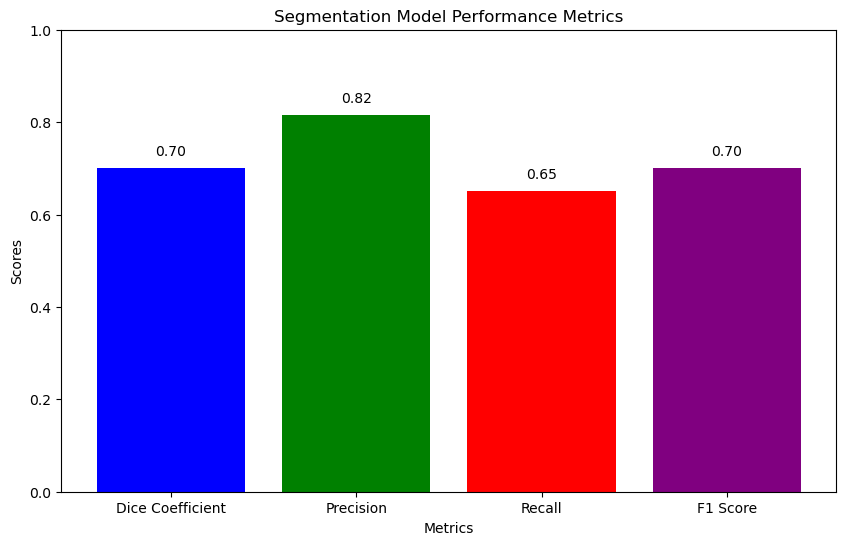

In [13]:
# Metrics names and values
metrics = ['Dice Coefficient', 'Precision', 'Recall', 'F1 Score']
values = [avg_dice, avg_precision, avg_recall, avg_f1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Segmentation Model Performance Metrics')
plt.ylabel('Scores')
plt.xlabel('Metrics')

# Annotating the bars with the values
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

# Data augmantation

Data augmentation is a crucial technique to artificially increase the diversity of the training data. This code sets up an image data generator that will apply random transformations (rotations, shifts, zooms, flips) to the training images and masks. This helps the model generalize better and reduces overfitting.

In [37]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
# Add an extra dimension to masks to make them compatible with ImageDataGenerator
Y = np.expand_dims(Y, axis=-1)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X, augment=True, seed=seed)
mask_datagen.fit(Y, augment=True, seed=seed)

image_generator = image_datagen.flow(X, batch_size=1, seed=seed)
mask_generator = mask_datagen.flow(Y, batch_size=1, seed=seed)

# Combine generators into one which yields image and masks
augmented_images = []
augmented_masks = []

for i in range(len(X)):
    aug_images, aug_masks = next(zip(image_generator, mask_generator))
    augmented_images.extend(aug_images)
    augmented_masks.extend(aug_masks)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (335, 240, 240, 2) (2 channels).
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (335, 240, 240, 2) (2 channels).
  warnings.warn(


In [39]:
final_Y_train = np.concatenate((Y, augmented_masks[:len(Y)]), axis=0)
final_X_train=np.concatenate((X, augmented_images[:len(X)]), axis=0)

In [29]:
Y_train.shape

(335, 240, 240, 1)

In [51]:
print(f'All Masks: {len(final_Y_train)}')
print(f'All Images: {len(final_X_train)}')



All Masks: 670
All Images: 670


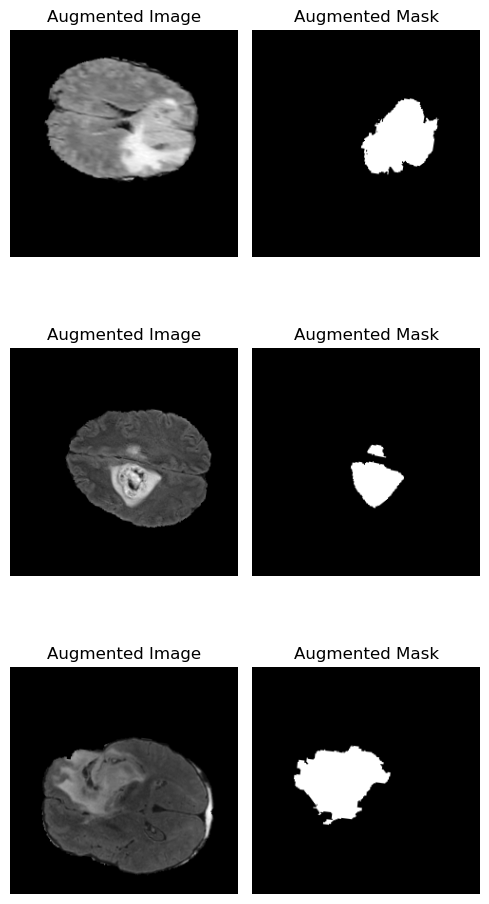

In [65]:
import matplotlib.pyplot as plt

# Fetch a batch of augmented images and masks
augmented_images, augmented_masks = next(train_generator)

# Plot the augmented images and masks
num_images_to_show = 3
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(5, 10))

for i in range(num_images_to_show):
    # Display the augmented image
    axes[i, 0].imshow(augmented_images[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title('Augmented Image')
    axes[i, 0].axis('off')
    
    # Display the corresponding augmented mask
    axes[i, 1].imshow(augmented_masks[i, :, :, 0], cmap='gray')
    axes[i, 1].set_title('Augmented Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


## Enhanced U-Net and Final Training:

This section defines an enhanced U-Net model that includes batch normalization layers. Batch normalization can help stabilize the training process and potentially improve performance. The model is then trained on the augmented dataset for a longer number of epochs.



In [66]:
from tensorflow.keras.layers import BatchNormalization

def enhanced_unet(input_size=(256, 256, 2)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs, conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy, metrics=[MeanIoU(num_classes=2)])
    
    return model

model = enhanced_unet(input_size=(256, 256, 2))
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 256, 256,  │      1,216 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_10

 Total params: 31,055,813 (118.47 MB)

 Trainable params: 31,044,037 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('unet_brain_tumor_segmentation_plus_augmanted_data.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(final_X_train, final_Y_train, test_size=0.2, random_state=42)


In [149]:

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=4, callbacks=[checkpoint, early_stopping])


Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.7156 - mean_io_u_3: 0.4945
Epoch 1: val_loss improved from inf to 0.68818, saving model to unet_brain_tumor_segmentation_plus_augmanted_data.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 591s 6s/step - loss: 0.7155 - mean_io_u_3: 0.4946 - val_loss: 0.6882 - val_mean_io_u_3: 0.4784
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.6808 - mean_io_u_3: 0.4915
Epoch 2: val_loss improved from 0.68818 to 0.68312, saving model to unet_brain_tumor_segmentation_plus_augmanted_data.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 581s 5s/step - loss: 0.6808 - mean_io_u_3: 0.4915 - val_loss: 0.6831 - val_mean_io_u_3: 0.4784
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.6722 - mean_io_u_3: 0.4877
Epoch 3: val_loss did not improve from 0.68312
107/107 ━━━━━━━━━━━━━━━━━━━━ 587s 5s/step - loss: 0.6721 - mean_io_u_3: 0.4877 - val_loss: 0.6973 - val_mean_io_u_3: 0.4857
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.6687 - mean_

In [72]:

# Load the best model
model=load_model('unet_brain_tumor_segmentation_plus_augmanted_data.keras')

# Evaluate the model on the validation set
val_loss, val_miou = model.evaluate(X_val, Y_val)


4/4 ━━━━━━━━━━━━━━━━━━━━ 149s 37s/step - loss: 0.5357 - mean_io_u_3: 0.4850


## Performance Evaluation

Finally, the code evaluates the model's performance using several metrics. The Dice coefficient is a common metric for segmentation tasks, measuring the overlap between the predicted and true segmentation masks. Precision, recall, and F1 score are also calculated. These metrics are then visualized in a bar plot, providing a comprehensive view of the model's performance.

4/4 ━━━━━━━━━━━━━━━━━━━━ 150s 39s/step


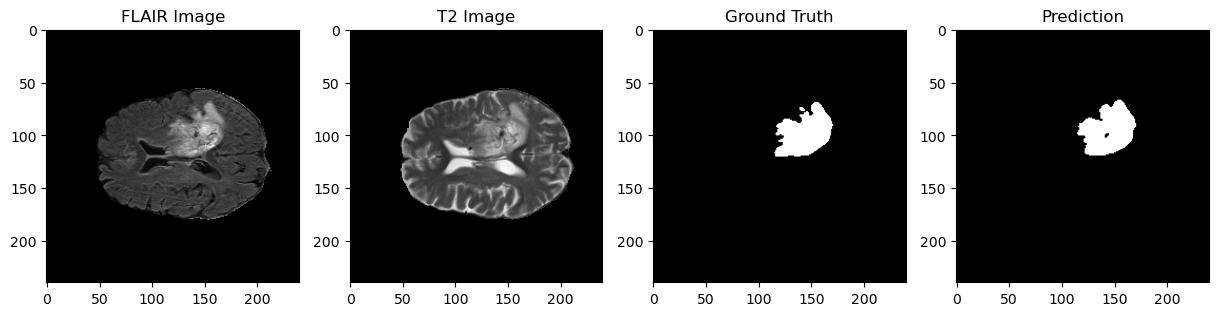

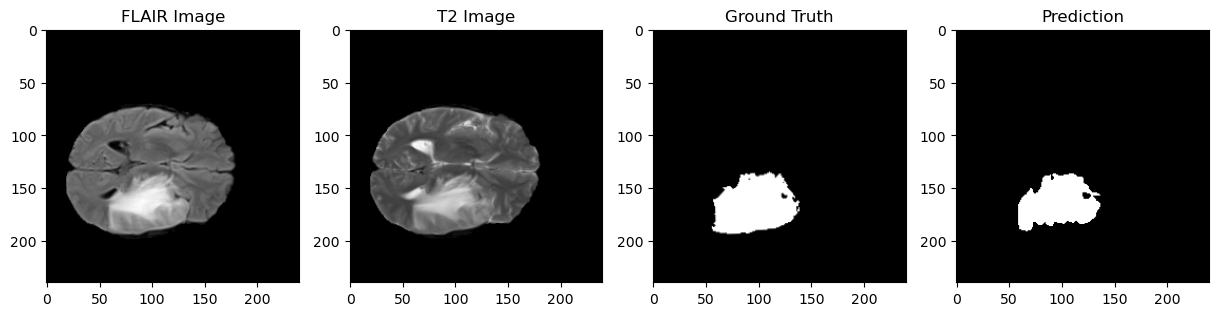

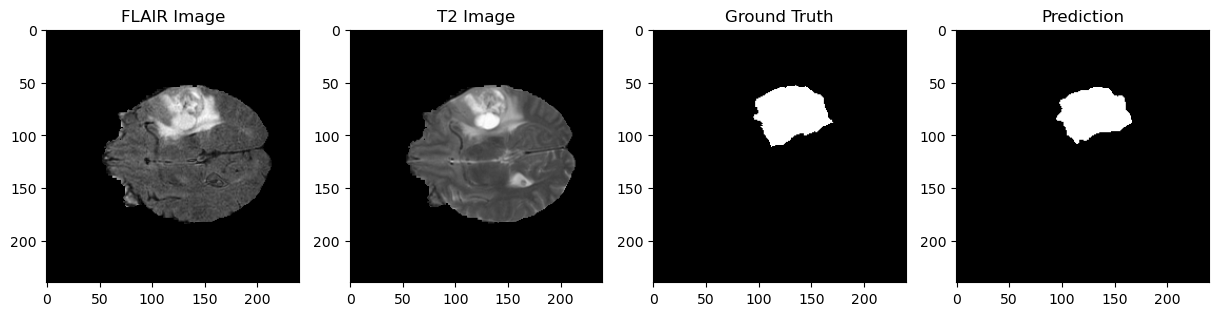

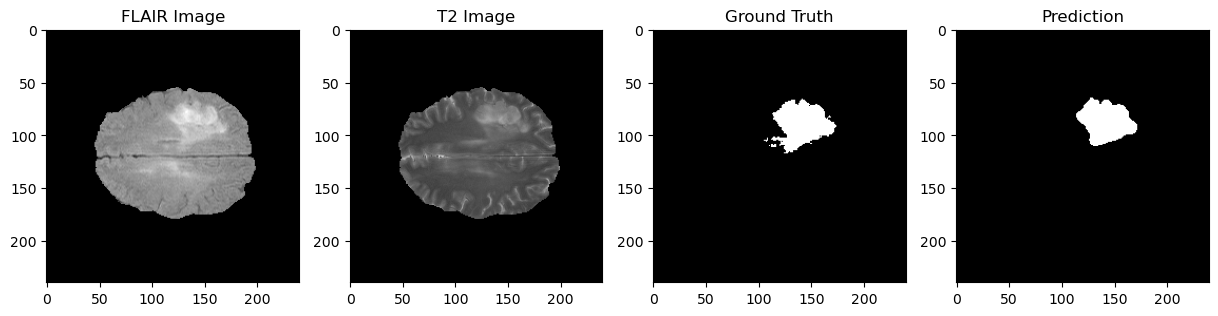

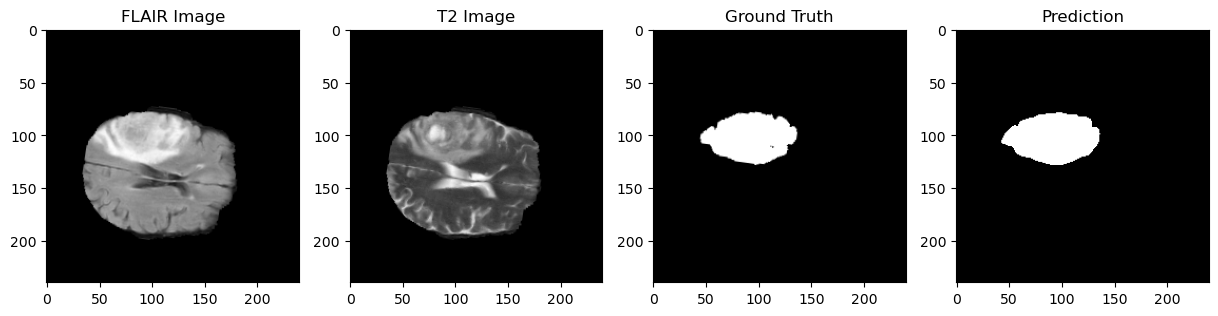

In [73]:
preds = model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)
num_images_to_show = 5
indices = np.random.choice(len(X_val), num_images_to_show, replace=False)

for idx in indices:
    plt.figure(figsize=(15, 5))
    
    # FLAIR image
    plt.subplot(1, 4, 1)
    plt.title('FLAIR Image')
    plt.imshow(X_val[idx, :, :, 0], cmap='gray')
    
    # T2 image
    plt.subplot(1, 4, 2)
    plt.title('T2 Image')
    plt.imshow(X_val[idx, :, :, 1], cmap='gray')
    
    # Ground Truth
    plt.subplot(1, 4, 3)
    plt.title('Ground Truth')
    plt.imshow(Y_val[idx], cmap='gray')
    
    # Prediction
    plt.subplot(1, 4, 4)
    plt.title('Prediction')
    plt.imshow(preds[idx, :, :, 0], cmap='gray')
    
    plt.show()

    


In [74]:
 
from sklearn.metrics import precision_score, recall_score, f1_score
 

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def evaluate_metrics(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    dice = dice_coefficient(y_true, y_pred)
    precision = precision_score(y_true_f, y_pred_f)
    recall = recall_score(y_true_f, y_pred_f)
    f1 = f1_score(y_true_f, y_pred_f)
    return dice, precision, recall, f1

# Make predictions
Y_pred = model.predict(X_val)

# Binarize predictions
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Evaluate the metrics
dice_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(len(Y_val_binary)):
    y_true = Y_val_binary[i]
    y_pred = Y_pred_binary[i]
    dice, precision, recall, f1 = evaluate_metrics(y_true, y_pred)
    dice_scores.append(dice)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

avg_dice = np.mean(dice_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f'Average Dice Coefficient: {avg_dice}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 143s 37s/step


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Average Dice Coefficient: 0.8608833100681096
Average Precision: 0.9278668330393967
Average Recall: 0.8362014858128884
Average F1 Score: 0.8608833100017406


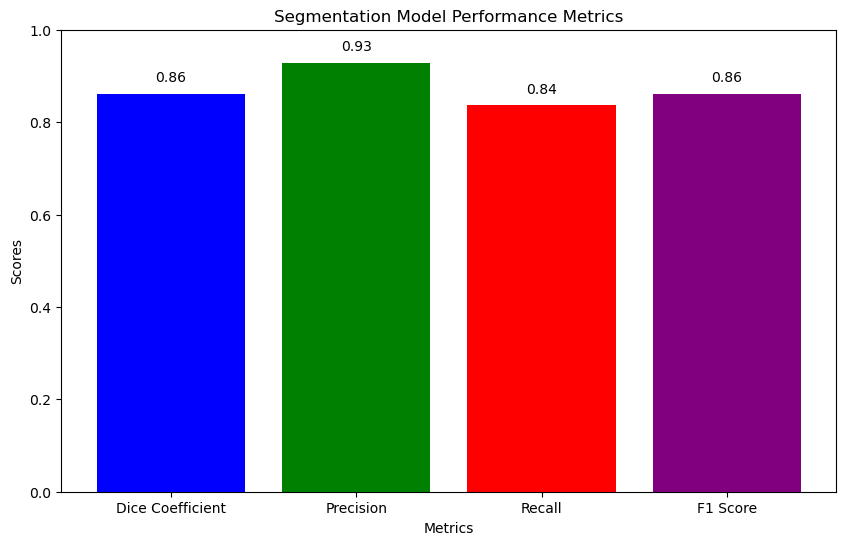

In [75]:



# Metrics names and values
metrics = ['Dice Coefficient', 'Precision', 'Recall', 'F1 Score']
values = [avg_dice, avg_precision, avg_recall, avg_f1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Segmentation Model Performance Metrics')
plt.ylabel('Scores')
plt.xlabel('Metrics')

# Annotating the bars with the values
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()
